# Classification: Point Trajectory

Exploring the trajectory of each facial point caputred by nuiCapture as a candidate feature.

<p>
    <img src="nuicapture.png">
    <em>Source: CadavidConcepts</em>
</p>

In [1]:
import glob as gl
import numpy as np
from scipy.io import loadmat
from typing import List
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
def labelname(file_name):
    label = file_name.replace("data/points/sample", "").lower()
    return label.replace(".mat", "")


class Signal:
    def __init__(self, x, y, label):
        self.x = x
        self.y = y
        self.label = label
        
    
def trajectory(sig):
    points_x = np.array(np.split(sig.x, 121, axis=1))
    points_y = np.array(np.split(sig.y, 121, axis=1))
    
    npoints, nrecs, nframes = np.shape(points_x)
    
    distances = np.empty((nrecs, npoints))
    
    # TO DO: normalizar
    # Calcula distância euclidiana entre (x,y) do frame atual e (x,y) do próximo frame
    # Resultado é registrado como soma acumulada das distâncias percorridas por cada ponto entre frames
    for r in range(nrecs):
        for p in range(npoints):
            distances[r][p] = 0
            for f in range(nframes-1):
                current_frame = [points_x[p, r, f], points_y[p, r, f]]
                next_frame = [points_x[p, r, f+1], points_y[p, r, f+1]]
                distances[r][p] += distance.euclidean(current_frame, next_frame)
    
    return np.argsort(-distances, axis=1)

In [3]:
files = gl.glob("data/points/*.mat")  # type: list
signals = []  # type: List[Signal]

for f in files:
    data = loadmat(f).get('pontosSinal')
    signals.append(Signal(data[:, ::2], data[:, 1::2], labelname(f)))

nsigns = len(signals)
nrecs, n_x = np.shape(signals[0].x)  # Number of recordings and number of features
nframes = 5

signals_feat = []  # Updated signals, according to each experiment
signals_labels = []
labels_dict = {}  # Dictionary of signals' labels, for reference
i = 0

for s in signals:
    signals_feat.append(trajectory(s))
    signals_labels.append([i] * nrecs)
    labels_dict[i] = s.label
    i += 1

signals_feat = pd.DataFrame(data=np.vstack(signals_feat)) # 100 x 121

sig_mode = []

i = 0
for s in signals:
    sig_sorted = pd.DataFrame(np.sort(np.array(signals_feat.loc[i*10:(i*10+9), 0:11]), axis=1))
    sig_mode.append(sig_sorted.mode(axis=0).loc[0,:].astype(int))
    i += 1

sig_mode = pd.DataFrame(data=sig_mode)
sig_labels = np.reshape(signals_labels, (nsigns * nrecs,))

In [4]:
# Moda dos 10% pontos de maior distância acumulada para cada sinal
# Gravações que mais se diferenciam da moda
# Número de pontos diferentes da moda

for i in range(nsigns):
    print("Signal: ", signals[i].label)
    result_sorted = pd.DataFrame(np.sort(np.array(signals_feat.loc[i*10:(i*10+9), 0:11]), axis=1))
    print(np.shape(result_sorted))
    result_mode = result_sorted.mode(axis=0).loc[0,:]
    print("Mode: ", np.array(result_mode.astype(int)))
    distance_mode = []
    for j in range(nrecs):
        distance_mode.append(len(result_mode) - len(list(set(result_sorted.loc[j,:]).intersection(result_mode))))
    distance_mode = np.array(distance_mode)
    index = (np.argsort(-distance_mode))[0:3]
    print("Most distant from mode: ", np.sort(np.array(index)))
    print(pd.DataFrame(data=distance_mode.astype(int)))
    print()

Signal:  acalmar
(10, 12)
Mode:  [  2  19  20  43  44  47  68  71  81  92 116 120]
Most distant from mode:  [0 6 7]
   0
0  2
1  1
2  1
3  0
4  1
5  1
6  2
7  3
8  2
9  1

Signal:  acusar
(10, 12)
Mode:  [  2  19  20  26  43  44  57  57  68  81  92 116]
Most distant from mode:  [0 1 2]
   0
0  2
1  1
2  2
3  1
4  1
5  1
6  1
7  1
8  1
9  1

Signal:  aniquilar
(10, 12)
Mode:  [  2  19  20  26  43  44  50  57  68  81  92 116]
Most distant from mode:  [0 2 7]
   0
0  1
1  0
2  1
3  0
4  1
5  0
6  0
7  2
8  0
9  1

Signal:  apaixonado
(10, 12)
Mode:  [  2  19  20  26  43  44  57  57  68  81  92 116]
Most distant from mode:  [1 2 7]
   0
0  1
1  3
2  3
3  1
4  1
5  1
6  1
7  4
8  1
9  1

Signal:  engordar
(10, 12)
Mode:  [  2  19  20  26  43  44  57  57  68  81  92 116]
Most distant from mode:  [0 1 2]
   0
0  1
1  1
2  1
3  1
4  1
5  1
6  1
7  1
8  1
9  1

Signal:  felicidade
(10, 12)
Mode:  [  2  19  20  26  43  44  57  68  68  81  92 116]
Most distant from mode:  [0 1 9]
   0
0  1
1  1
2

In [5]:
sig_mode = []
i = 0
for s in signals:
    sig_sorted = pd.DataFrame(np.sort(np.array(signals_feat.loc[i*10:(i*10+9), 0:11]), axis=1))
    sig_mode.append(sig_sorted.mode(axis=0).loc[0,:].astype(int))
    i += 1

sig_mode = np.array(sig_mode)
frame_x = []
frame_y = []
nidx, nmodes = np.shape(sig_mode)

for s in signals:
    frame_x.append(np.split(s.x, 5, axis=1))
    frame_y.append(np.split(s.y, 5, axis=1))

frame_x = np.array(frame_x)
frame_y = np.array(frame_y)
new_frame_x = []
new_frame_y = []

for s in range(nsigns):
    mode = sig_mode[s,:]
    new_frame_x.append(np.transpose(frame_x[s,:,:,mode]))
    new_frame_y.append(np.transpose(frame_y[s,:,:,mode]))

sig_features = np.empty((nrecs*nsigns, nframes*nmodes*2))
sig_features[:,::2] = (np.vstack(new_frame_x)).reshape(100,60)
sig_features[:,1::2] = (np.vstack(new_frame_y)).reshape(100,60)

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from pprint import pprint

In [7]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 7]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [8]:
niter = 30
results = []
train_acc = []
test_acc = []
train_report =[]
class_report = []
selected_params = []
cm = [] # confusion matrix
feature_importance = []
col_names = range(1,1211)

for i in range(niter):
    print("Iteration:: ", i)
    sss = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
    sss.get_n_splits(sig_features, sig_labels)

    for train_index, test_index in sss.split(sig_features, sig_labels):
        train_x, test_x = sig_features[train_index], sig_features[test_index]
        train_y, test_y = sig_labels[train_index], sig_labels[test_index]

    rf = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=1, n_jobs=-1)

    rf_random.fit(train_x, train_y)
    predictions = rf_random.predict(test_x)
    
    selected_params.append(rf_random.best_params_)
    train_acc.append(accuracy_score(train_y, rf_random.predict(train_x)))
    test_acc.append(accuracy_score(test_y, predictions))
    cm.append(confusion_matrix(test_y, predictions, labels=test_y))
    class_report.append(classification_report(test_y, predictions, target_names=list(labels_dict.values())))
    feature_importance.append(pd.DataFrame(data=sorted(zip(map(lambda x: round(x, 4), 
                                                               rf_random.best_estimator_.feature_importances_), 
                                                           col_names), reverse=True)))

Iteration::  0
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.5min finished


Iteration::  1
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.5min finished


Iteration::  2
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.7min finished


Iteration::  3
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.3min finished


Iteration::  4
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.0min finished


Iteration::  5
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.8min finished


Iteration::  6
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.4min finished


Iteration::  7
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.5min finished


Iteration::  8
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.8min finished


Iteration::  9
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.7min finished


Iteration::  10
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.2min finished


Iteration::  11
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.3min finished


Iteration::  12
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.0min finished


Iteration::  13
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.2min finished


Iteration::  14
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.7min finished


Iteration::  15
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.1min finished


Iteration::  16
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.7min finished


Iteration::  17
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.3min finished


Iteration::  18
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.1min finished


Iteration::  19
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.5min finished


Iteration::  20
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.3min finished


Iteration::  21
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.8min finished


Iteration::  22
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.4min finished


Iteration::  23
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.8min finished


Iteration::  24
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.8min finished


Iteration::  25
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 980.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 983.2min finished


Iteration::  26
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.4min finished


Iteration::  27
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.2min finished


Iteration::  28
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.4min finished


Iteration::  29
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.0min finished
/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<IPython.core.display.Javascript object>


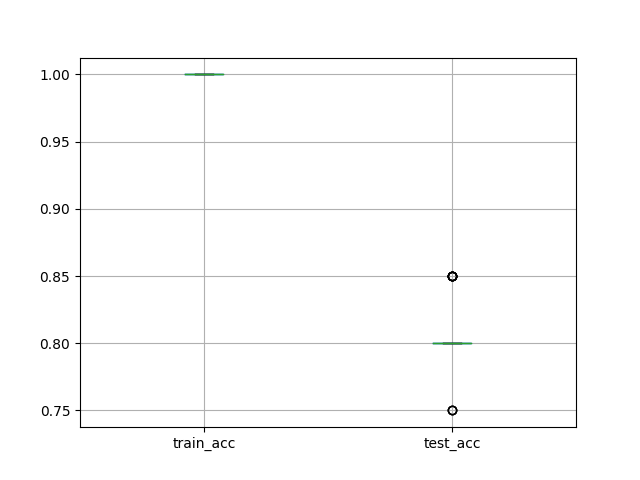

In [12]:
import pandas as pd
import numpy as np
acc = np.transpose([train_acc, test_acc])
acc = pd.DataFrame(data=acc, columns=['train_acc', 'test_acc'])
boxplot = acc.boxplot(column=['train_acc', 'test_acc'])
plt.show()

In [20]:
np.savetxt("disptrainacc.csv",train_acc,delimiter=",")
np.savetxt("disptestacc.csv",test_acc,delimiter=",")

In [25]:
np.savetxt('dispselected_params.txt',selected_params,fmt='%s',delimiter='\n')
np.savetxt("dispclassreport.txt",class_report,fmt='%s',delimiter='\n')

import pickle
with open('dispcm.txt', 'wb') as fp:
    pickle.dump(cm, fp)
with open('dispfeatimportance.txt', 'wb') as fp:
    pickle.dump(feature_importance, fp)

In [26]:
acc.describe()

,train_acc,test_acc
count,30.0,30.000000
mean,1.0,0.806667
std,0.0,0.028567
min,1.0,0.750000
25%,1.0,0.800000
50%,1.0,0.800000
75%,1.0,0.800000
max,1.0,0.850000
